In [1]:
import mnist # This is the same as tensorflow.examples.tutorials.mnist.mnist, included for convenience
import tensorflow as tf

In [2]:
# First we need data. Tensorflow provides us with a convenient way to download and store the MNIST data.
from tensorflow.examples.tutorials.mnist import input_data
# This will download the data
data = input_data.read_data_sets('/tmp/tensorflow_tutorial')
print(data)

Extracting /tmp/tensorflow_tutorial/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow_tutorial/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow_tutorial/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow_tutorial/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe4bd4aec18>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe4bd4c2e10>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7fe4bd4c2828>)


In [3]:
# To perform training, we need to add a loss function and optimiser to our computation graph.
# Luckily, these are already defined in mnist.py. Let's have a look at what they need.
print(mnist.inference.__doc__)

Build the MNIST model up to where it may be used for inference.

  Args:
    images: Images placeholder, from inputs().
    hidden1_units: Size of the first hidden layer.
    hidden2_units: Size of the second hidden layer.

  Returns:
    softmax_linear: Output tensor with the computed logits.
  


In [4]:
print(mnist.loss.__doc__)

Calculates the loss from the logits and the labels.

  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size].

  Returns:
    loss: Loss tensor of type float.
  


In [5]:
print(mnist.training.__doc__)

Sets up the training Ops.

  Creates a summarizer to track the loss over time in TensorBoard.

  Creates an optimizer and applies the gradients to all trainable variables.

  The Op returned by this function is what must be passed to the
  `sess.run()` call to cause the model to train.

  Args:
    loss: Loss tensor, from loss().
    learning_rate: The learning rate to use for gradient descent.

  Returns:
    train_op: The Op for training.
  


In [6]:
# It would also be useful to have some evaluation metric:
print(mnist.evaluation.__doc__)

Evaluate the quality of the logits at predicting the label.

  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).

  Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
  


In [7]:
# So we need two placeholders: one for the labels and one for the images (flattened)
# shape(images) = [batch_size, image_pixels]
# shape(labels) = [batch_size]
batch_size = 100
image_placeholder = tf.placeholder(tf.float32, shape=(batch_size, mnist.IMAGE_PIXELS), name="images")
label_placeholder = tf.placeholder(tf.int32, shape=(batch_size), name="labels")

In [8]:
# Now we need to construct the rest of the graph (and connect it to our placeholders), consisting of:
# - Main network (inference part)
# - Loss
# - Optimizer
# - Evaluation

# Proper namespacing makes the Tensorboard graph view much more pleasant!

with tf.name_scope("inference"):
    # Input to inference part is image_placeholder
    logits = mnist.inference(image_placeholder, 128, 32) 

with tf.name_scope("loss"):
    # Input to loss are output of inference and label_placeholder
    loss = mnist.loss(logits, label_placeholder)

with tf.name_scope("training"):
    # Optimizer only needs to be connected to the loss
    optimizer = mnist.training(loss, 0.01)

with tf.name_scope("evaluation"):
    # For evaluation, only need output of inference (i.e. prediction) and labels
    evaluation = mnist.evaluation(logits, label_placeholder)

In [9]:
# Now we set up 2 utility operations (note that these are still all part of the graph!)

# Running this operation initialises all variables
# (so e.g. it assigns the output of tf.truncated_normal to the weights variables)
init = tf.global_variables_initializer()

# This calls all tf.summary operations in the graph.
# E.g. if you want to log the loss to Tensorboard and various other statistics, you could evaluate this op instead
# having to evaluate all logging ops.
summary = tf.summary.merge_all()

In [10]:
# Our graph is all set!
# Now we need a Session to actually run it, and a FileWriter to write logs for Tensorboard

# By default, tf.Session() will use the default graph, and store it in sess.graph
sess = tf.Session()

# Delete the log directory first
if tf.gfile.Exists('logs'):
    tf.gfile.DeleteRecursively('logs')
summary_writer = tf.summary.FileWriter('logs', sess.graph)

# To make sure we don't accidentally add more operations to the graph (which is easily done!), call finalize()
# This will throw an error if you try to add something to the graph afterwards
sess.graph.finalize()

In [11]:
# We need to run the `init` op we created, so that all variables get initialised
sess.run(init)

# Let's flush the summary_writer, so that our graph is written to Tensorboard, so we can see what we created
summary_writer.flush()

# Run in a terminal: `tensorboard --logdir=logs`

In [12]:
# We need to define a function that executes the evaluation part of the tree, so that we can reuse it for
# various datasets (train set, validation set, test set)
# Borrowed (modified) from: tensorflow/examples/tutorials/mnist/fully_connected_feed.py
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set):
  """Runs one evaluation against the full epoch of data.
  Args:
    sess: The session in which the model has been trained.
    eval_correct: The Tensor that returns the number of correct predictions.
    images_placeholder: The images placeholder.
    labels_placeholder: The labels placeholder.
    data_set: The set of images and labels to evaluate, from
      input_data.read_data_sets().
  """
  # And run one epoch of eval.
  true_count = 0  # Counts the number of correct predictions.
  steps_per_epoch = data_set.num_examples // batch_size
  num_examples = steps_per_epoch * batch_size
  for step in range(steps_per_epoch):
    images, labels = data_set.next_batch(batch_size)
    feed_dict = {
        image_placeholder: images,
        label_placeholder: labels,
    }
    true_count += sess.run(eval_correct, feed_dict=feed_dict)
  precision = float(true_count) / num_examples
  print('  Num examples: %d  Num correct: %d  Precision: %0.04f' %
        (num_examples, true_count, precision))

In [13]:
# Now we're good to start training
# Let's write the train loop. Say 2000 steps (i.e. 2000 batches of training data, which is 2000*100=200k examples)

for step in range(2000):
    
    # Ask the dataset for the next batch
    # This will load the data from disk into numpy arrays, which then can be fed into our placeholders
    images, labels = data.train.next_batch(batch_size)
    
    # Feed this to our placeholders and run the train and loss parts of our graph
    # Note that the loss part is part of the train part: Tensorflow is smart enough to run this only once :)
    # loss_value is now just numpy data, and not a tensor anymore.
    feed_dict = {
        image_placeholder: images,
        label_placeholder: labels,
    }
    _, loss_value = sess.run([optimizer, loss], feed_dict=feed_dict)
    
    # Every 100 steps, write summaries to stdout and Tensorboard
    if step % 100 == 0:
        print('Step %d: loss = %.2f' % (step, loss_value))
        summary_str = sess.run(summary, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        summary_writer.flush()
        
    # Every 1000 steps evaluate the model against the training, validation and test set
    # Save a checkpoint and evaluate the model periodically.
    if (step + 1) % 1000 == 0:
        # Evaluate against the training set.
        print('Training Data Eval:')
        do_eval(sess,
                evaluation,
                image_placeholder,
                label_placeholder,
                data.train)
        # Evaluate against the validation set.
        print('Validation Data Eval:')
        do_eval(sess,
                evaluation,
                image_placeholder,
                label_placeholder,
                data.validation)
        # Evaluate against the test set.
        print('Test Data Eval:')
        do_eval(sess,
                evaluation,
                image_placeholder,
                label_placeholder,
                data.test)

Step 0: loss = 2.30
Step 100: loss = 2.05
Step 200: loss = 1.73
Step 300: loss = 1.30
Step 400: loss = 1.00
Step 500: loss = 0.80
Step 600: loss = 0.63
Step 700: loss = 0.55
Step 800: loss = 0.54
Step 900: loss = 0.55
Training Data Eval:
  Num examples: 55000  Num correct: 47718  Precision: 0.8676
Validation Data Eval:
  Num examples: 5000  Num correct: 4389  Precision: 0.8778
Test Data Eval:
  Num examples: 10000  Num correct: 8723  Precision: 0.8723
Step 1000: loss = 0.51
Step 1100: loss = 0.43
Step 1200: loss = 0.46
Step 1300: loss = 0.38
Step 1400: loss = 0.39
Step 1500: loss = 0.41
Step 1600: loss = 0.53
Step 1700: loss = 0.41
Step 1800: loss = 0.40
Step 1900: loss = 0.39
Training Data Eval:
  Num examples: 55000  Num correct: 49498  Precision: 0.9000
Validation Data Eval:
  Num examples: 5000  Num correct: 4537  Precision: 0.9074
Test Data Eval:
  Num examples: 10000  Num correct: 9057  Precision: 0.9057


In [14]:
# Run Tensorboard again

[6 1 1 3 7 9 4 8 5 4 0 8 1 0 9 2 9 3 1 9 8 8 3 5 3 3 3 1 9 3 6 3 9 5 1 5 6
 4 2 9 6 4 1 3 0 9 0 3 9 0 3 5 5 3 4 7 0 2 7 1 8 1 3 4 9 8 0 3 4 3 9 9 0 9
 0 2 6 1 1 3 7 9 4 2 4 0 8 0 8 2 1 2 7 0 9 5 4 7 9 3]


<IPython.core.display.Javascript object>


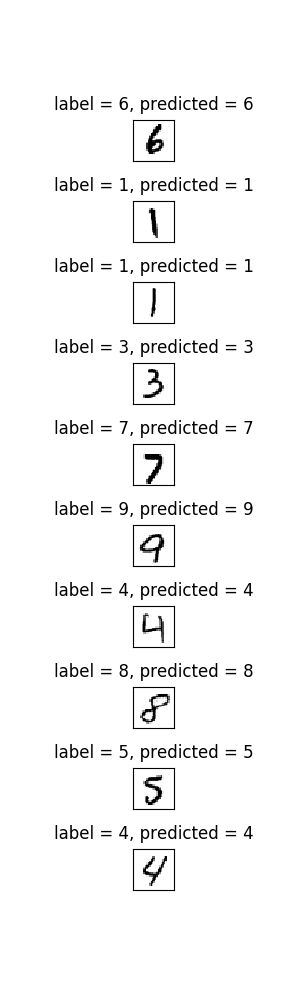

In [15]:
# We've trained a model. Let's visualise some predictions.

images, labels = data.train.next_batch(batch_size)

# No need to input labels for inference only
predictions = sess.run(logits, feed_dict={
    image_placeholder: images
})

# Predictions is a matrix of shape 100,10, where the 2nd dimension is a probability distribution over the 10 classes
import numpy as np
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

# Let's visualise these
%matplotlib notebook

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(3,10))
fig.subplots_adjust(hspace=1)
    
def plot(i, image, real_label, predicted_label):
    ax = fig.add_subplot(10, 1, i + 1)
    ax.matshow(image, cmap='binary')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.title("label = %d, predicted = %d" % (real_label, predicted_label))
    
for i in range(10):
    plot(i, np.reshape(images[i], (mnist.IMAGE_SIZE, mnist.IMAGE_SIZE)), labels[i], predicted_labels[i])